In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from utils.TD import TD_Adam, TD_SGD
from utils.NeuralNet import TwoLayerFCNN_Adam, TwoLayerFCNN_SGD

from utils import Benchmarking

seed = 42
torch.manual_seed(seed)

In [3]:
housedata = torch.tensor(np.loadtxt('data\\readyhousedata.txt', delimiter=','), dtype=torch.float32)

X = housedata[:, :-1]
y = housedata[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Parameters for TD
num_samples, num_features = X_train.shape
P = torch.ones((num_samples, num_samples)) / num_samples # Equal probability to move to any state

identity = lambda x : x
n_iter = 1e5
alpha = 0.01
epsilon = 1e-7

hidden_layers = 64
batch_size = 32
n_epochs = 100

In [5]:
# Initialise classes
td_sgd = TD_SGD(
    n_iter=1e5,
    P=P,
    link=identity,
    inv_link=identity,
    gamma=0,
    alpha=0.001,
    epsilon=1e-9,
)

td_adam = TD_Adam(
    n_iter=1e6,
    P=P,
    link=identity,
    inv_link=identity,
    gamma=0,
    alpha=0.01,
    epsilon=1e-8,
    betas=(0.9, 0.9999),
)

nn_sgd = TwoLayerFCNN_SGD(
    batch_size=32,
    lr=0.01,
    n_epochs=150,
    input_size=num_features,
    hidden_size=32,
)

nn_adam = TwoLayerFCNN_Adam(
    batch_size=32,
    lr=0.01,
    n_epochs=150,
    input_size=num_features,
    hidden_size=128,
)

In [6]:
# Train the TD models
td_sgd.fit(X_train, y_train)
td_adam.fit(X_train, y_train)

# Train the NN models
nn_sgd.fit(X_train, y_train)
nn_adam.fit(X_train, y_train)

Ending optimization early at iteration 37017
Epoch [1/150], Loss: 212.4256
Epoch [2/150], Loss: 59.1911
Epoch [3/150], Loss: 52.3092
Epoch [4/150], Loss: 53.4367
Epoch [5/150], Loss: 56.8924
Epoch [6/150], Loss: 38.0485
Epoch [7/150], Loss: 31.0112
Epoch [8/150], Loss: 29.8886
Epoch [9/150], Loss: 46.1557
Epoch [10/150], Loss: 42.4461
Epoch [11/150], Loss: 28.3701
Epoch [12/150], Loss: 39.6836
Epoch [13/150], Loss: 40.7681
Epoch [14/150], Loss: 31.0002
Epoch [15/150], Loss: 38.4284
Epoch [16/150], Loss: 28.3908
Epoch [17/150], Loss: 25.5331
Epoch [18/150], Loss: 33.8752
Epoch [19/150], Loss: 34.8745
Epoch [20/150], Loss: 23.5006
Epoch [21/150], Loss: 24.4346
Epoch [22/150], Loss: 28.6110
Epoch [23/150], Loss: 26.3033
Epoch [24/150], Loss: 21.9381
Epoch [25/150], Loss: 22.8994
Epoch [26/150], Loss: 25.7250
Epoch [27/150], Loss: 21.9701
Epoch [28/150], Loss: 23.1979
Epoch [29/150], Loss: 25.5000
Epoch [30/150], Loss: 24.9667
Epoch [31/150], Loss: 24.0709
Epoch [32/150], Loss: 35.2397
Epo

In [7]:
# Define noise standard deviation
noise_std = 0.1

# Add Gaussian noise to the test set
X_test_noisy = X_test + torch.randn(X_test.shape) * noise_std

In [8]:
# TD predictions on original and noisy test sets
y_pred_td_sgd = td_sgd.predict(X_test)
y_pred_td_sgd_noisy = td_sgd.predict(X_test_noisy)

y_pred_td_adam = td_adam.predict(X_test)
y_pred_td_adam_noisy = td_adam.predict(X_test_noisy)

# NN predictions on original and noisy test sets
y_pred_nn_sgd = nn_sgd.predict(X_test)
y_pred_nn_sgd_noisy = nn_sgd.predict(X_test_noisy)

y_pred_nn_adam = nn_adam.predict(X_test)
y_pred_nn_adam_noisy = nn_adam.predict(X_test_noisy)

In [9]:
# Measure the average change in output values for all methods
change_td_sgd = Benchmarking.mean_absolute_diff(y_pred_td_sgd, y_pred_td_sgd_noisy)
change_td_adam = Benchmarking.mean_absolute_diff(y_pred_td_adam, y_pred_td_adam_noisy)
change_nn_sgd = Benchmarking.mean_absolute_diff(y_pred_nn_sgd, y_pred_nn_sgd_noisy)
change_nn_adam = Benchmarking.mean_absolute_diff(y_pred_nn_adam, y_pred_nn_adam_noisy)

# Print the results
print(f"Average change for TD-SGD: {change_td_sgd}")
print(f"Average change for TD-Adam: {change_td_adam}")
print(f"Average change for NN-SGD: {change_nn_sgd}")
print(f"Average change for NN-Adam: {change_nn_adam}")

Average change for TD-SGD: 2.6134142875671387
Average change for TD-Adam: 2.750765085220337
Average change for NN-SGD: 3.5425167083740234
Average change for NN-Adam: 4.472158432006836


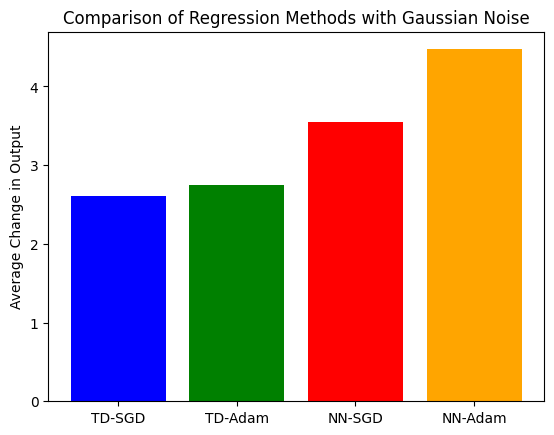

In [10]:
# Plot the changes in predictions
Benchmarking.plot_noise_diff(
    td_sgd=change_td_sgd, 
    td_adam=change_td_adam, 
    nn_sgd=change_nn_sgd, 
    nn_adam=change_nn_adam,
    )

In [11]:
print(f"RMSE for TD-SGD {td_sgd.rmse(X_test, y_test)}")
print(f"RMSE for TD-ADAM {td_adam.rmse(X_test, y_test)}")
print(f"RMSE for NN-SGD {nn_sgd.evaluate(X_test, y_test)}")
print(f"RMSE for NN-ADAM {nn_adam.evaluate(X_test, y_test)}")

RMSE for TD-SGD 3.9053268432617188
RMSE for TD-ADAM 4.025970935821533
RMSE for NN-SGD 7.9043474197387695
RMSE for NN-ADAM 7.859739661216736


In [12]:
print(f"RMSE for noisy TD-SGD {td_sgd.rmse(X_test_noisy, y_test)}")
print(f"RMSE for noisy TD-ADAM {td_adam.rmse(X_test_noisy, y_test)}")
print(f"RMSE for noisy NN-SGD {nn_sgd.evaluate(X_test_noisy, y_test)}")
print(f"RMSE for noisy NN-ADAM {nn_adam.evaluate(X_test_noisy, y_test)}")

RMSE for noisy TD-SGD 5.640848636627197
RMSE for noisy TD-ADAM 5.7931599617004395
RMSE for noisy NN-SGD 25.09207785129547
RMSE for noisy NN-ADAM 43.93395519256592
